In [16]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))
from Utils.data_utils import load_preprocessed_data_from_folder

# Load the data from the CSV file into a pandas DataFrame
data = load_preprocessed_data_from_folder()

data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.513755,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,0.610408,0.719411,0.497319,0.450999,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,0.584737,0.414652,0.562017,0.532866,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327,0.0
...,...,...,...,...,...,...,...,...,...,...
3991,0.482531,0.524160,0.308924,0.442628,0.504566,0.407946,0.539767,0.485483,0.599330,1.0
3992,0.371926,0.442095,0.411976,0.546609,0.596498,0.292375,0.416480,0.524698,0.460797,1.0
3993,0.471553,0.290820,0.524454,0.747456,0.432994,0.558864,0.430764,0.599290,0.580482,1.0
3994,0.483064,0.484272,0.490260,0.783886,0.364165,0.535721,0.349975,0.552053,0.439660,1.0


In [7]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.1
NUM_FOLDS = 5

train_df, test_df = train_test_split(data, test_size=TEST_SIZE)
train_df, test_df

(            ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
 3397  0.485710  0.466294  0.360950     0.508502  0.660687      0.431919   
 3356  0.423641  0.604996  0.450609     0.304303  0.568606      0.273446   
 460   0.512847  0.483954  0.173030     0.619296  0.603080      0.308769   
 1379  0.335394  0.549448  0.401375     0.589256  0.637685      0.579440   
 3434  0.556027  0.535176  0.278663     0.593597  0.601472      0.357543   
 ...        ...       ...       ...          ...       ...           ...   
 1298  0.661917  0.565198  0.330965     0.507771  0.591709      0.571469   
 2093  0.514114  0.604965  0.307123     0.570076  0.584489      0.419083   
 1463  0.538881  0.481290  0.278007     0.421859  0.597366      0.689748   
 2546  0.224908  0.344007  0.376583     0.620530  0.466325      0.367849   
 1716  0.534029  0.720923  0.439839     0.738940  0.602685      0.276723   
 
       Organic_carbon  Trihalomethanes  Turbidity  Potability  
 3397        0.226858 

In [8]:
# bisect the data into features and target (potability)
train_x = train_df.drop('Potability', axis=1)
train_y = train_df['Potability']

test_x = test_df.drop('Potability', axis=1)
test_y = test_df['Potability']

In [9]:
# Naive random forest model

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(train_x, train_y)

print(f'Random Forest test score: {random_forest.score(test_x, test_y):0.2%}')

Random Forest test score: 74.00%


In [13]:
from sklearn.model_selection import GridSearchCV

params = {
  'n_estimators': [100, 200],
  'max_depth': [None, 10, 20, 50],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4],
  'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(random_forest, params, scoring='f1', verbose=4, cv=NUM_FOLDS, n_jobs=-1)
grid_search.fit(train_x, train_y)

best_params = grid_search.best_params_

print(f'Random Forest test score: {grid_search.score(test_x, test_y):0.2%}')
print(f'Random Forest F1 score: {grid_search.best_score_:0.2%}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Random Forest test score: 73.28%
Random Forest F1 score: 73.15%


In [17]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f'Best model: {best_model}, best params: {best_params}')
print(f'Best model F1 score: {f1_score(test_y, best_model.predict(test_x)):0.2%}')

Best model: RandomForestClassifier(min_samples_split=5, n_estimators=200), best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best model F1 score: 73.28%


In [18]:
# Perform a manual search to graph the F1 score against the max_depth

max_depths = range(1, 50 + 1)
scores = []

for max_depth in max_depths:
  # print(f'start: {max_depth}')
  params = dict(best_params, max_depth=max_depth)
  random_forest = RandomForestClassifier(**params)
  random_forest.fit(train_x, train_y)
  score = f1_score(test_y, random_forest.predict(test_x))
  scores.append(score)
  # print(f'end: {max_depth}')


# Modify the best params' max_depth accordingly
best_max_depth = max_depths[np.argmax(scores)]
best_params['max_depth'] = best_max_depth

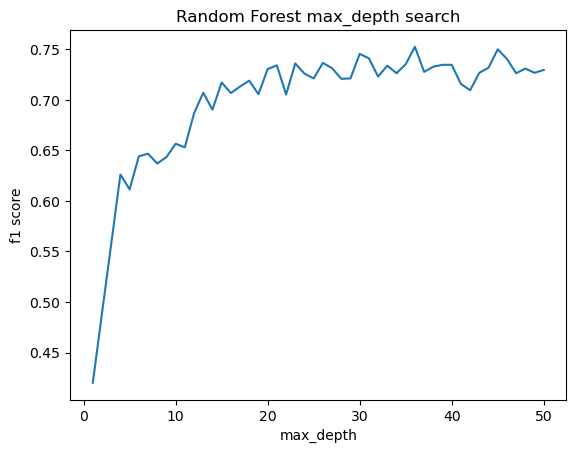

In [19]:
# Plot the search results

plt.plot(max_depths, scores)
plt.xlabel('max_depth')
plt.ylabel('f1 score')
plt.title('Random Forest max_depth search')

plt.show()

In [20]:
from sklearn.calibration import CalibratedClassifierCV

ideal_rf = RandomForestClassifier(**best_params)

calibrated_rf = CalibratedClassifierCV(ideal_rf, cv=NUM_FOLDS)
calibrated_rf.fit(train_x, train_y)

ideal_rf_prefit = RandomForestClassifier(**best_params)
ideal_rf_prefit.fit(train_x, train_y)

calibrated_rf_prefit = CalibratedClassifierCV(ideal_rf_prefit, cv='prefit')
calibrated_rf_prefit.fit(train_x, train_y)

print(f'Calibrated Random Forest (cv={NUM_FOLDS}) test score: {calibrated_rf.score(test_x, test_y):0.2%}')
print(f'Calibrated Random Forest (cv=prefit) test score: {calibrated_rf_prefit.score(test_x, test_y):0.2%}')

Calibrated Random Forest (cv=5) test score: 72.25%
Calibrated Random Forest (cv=prefit) test score: 73.75%


In [21]:
calibrated_rf.predict_proba(test_x)

array([[0.73191792, 0.26808208],
       [0.62748199, 0.37251801],
       [0.76716758, 0.23283242],
       [0.27685519, 0.72314481],
       [0.2077468 , 0.7922532 ],
       [0.30551708, 0.69448292],
       [0.74238787, 0.25761213],
       [0.38296623, 0.61703377],
       [0.4418677 , 0.5581323 ],
       [0.48396676, 0.51603324],
       [0.86461133, 0.13538867],
       [0.61321063, 0.38678937],
       [0.34777675, 0.65222325],
       [0.66745394, 0.33254606],
       [0.40231151, 0.59768849],
       [0.06498908, 0.93501092],
       [0.70384262, 0.29615738],
       [0.87542971, 0.12457029],
       [0.10790481, 0.89209519],
       [0.52845347, 0.47154653],
       [0.48245369, 0.51754631],
       [0.33296853, 0.66703147],
       [0.39554216, 0.60445784],
       [0.45816485, 0.54183515],
       [0.80913516, 0.19086484],
       [0.28451998, 0.71548002],
       [0.24132628, 0.75867372],
       [0.36149685, 0.63850315],
       [0.6789032 , 0.3210968 ],
       [0.23924765, 0.76075235],
       [0.

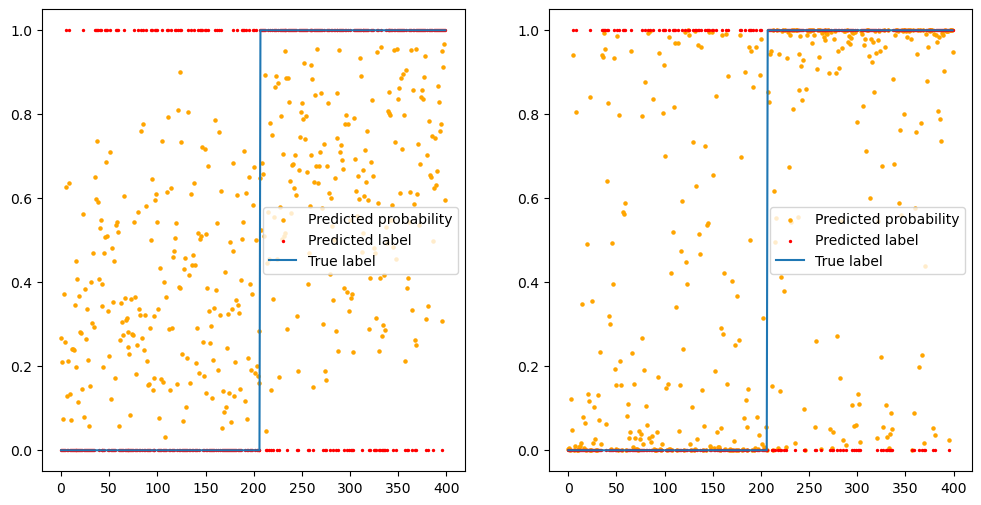

In [22]:
# Create a zipped array of sample index, predicted proability and true label
results = np.column_stack((
  calibrated_rf.predict_proba(test_x)[:, 1], 
  calibrated_rf.predict(test_x), 
  calibrated_rf_prefit.predict_proba(test_x)[:, 1],
  calibrated_rf_prefit.predict(test_x),
  test_y
  ))

# Sort by true label
results = results[results[:, -1].argsort()]

# Plot the predicted probabilities & true labels

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(range(len(results)), results[:, 0], label='Predicted probability', c='orange', s=5)
plt.scatter(range(len(results)), results[:, 1], label='Predicted label', c='red', s=2)
plt.plot(results[:, -1], label='True label')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(results)), results[:, 2], label='Predicted probability', c='orange', s=5)
plt.scatter(range(len(results)), results[:, 3], label='Predicted label', c='red', s=2)
plt.plot(results[:, -1], label='True label')
plt.legend()

plt.show()




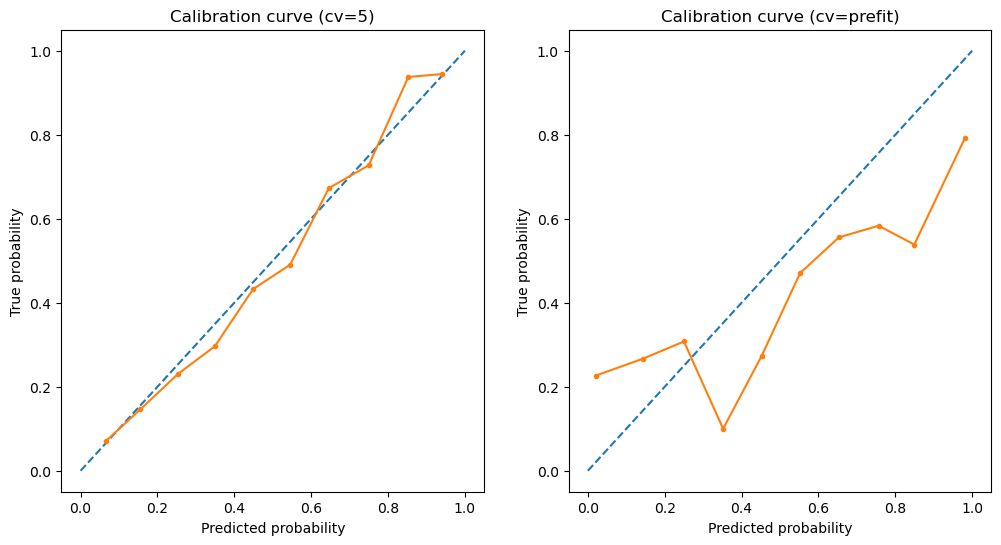

In [23]:
from sklearn.calibration import calibration_curve

# Plot the calibration curve for the two models

plt.figure(figsize=(12, 6))

prob_true, prob_pred = calibration_curve(test_y, calibrated_rf.predict_proba(test_x)[:, 1], n_bins=10)

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(prob_pred, prob_true, marker='.')
plt.title('Calibration curve (cv=5)')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')

prob_true, prob_pred = calibration_curve(test_y, calibrated_rf_prefit.predict_proba(test_x)[:, 1], n_bins=10)

plt.subplot(1, 2, 2)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(prob_pred, prob_true, marker='.')
plt.title('Calibration curve (cv=prefit)')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')

plt.show()

In [24]:
# Try optimizing the hyperparameters with optuna
import optuna
from sklearn.model_selection import cross_val_score

N_TRIALS = 100

def objective(trial: optuna.Trial) -> float:
  params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 200),
    'max_depth': trial.suggest_int('max_depth', 1, 50),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
    'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
  }

  random_forest = RandomForestClassifier(**params)
  
  scores = cross_val_score(random_forest, train_x, train_y, scoring='f1', cv=NUM_FOLDS)
  return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

[I 2024-04-20 18:51:40,704] A new study created in memory with name: no-name-afed701d-2901-460f-a1f4-7883955b1aa5
[I 2024-04-20 18:51:48,954] Trial 0 finished with value: 0.7194021825490762 and parameters: {'n_estimators': 118, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7194021825490762.
[I 2024-04-20 18:51:57,684] Trial 1 finished with value: 0.7241417287865843 and parameters: {'n_estimators': 128, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7241417287865843.
[I 2024-04-20 18:51:58,717] Trial 2 finished with value: 0.5336093670233935 and parameters: {'n_estimators': 124, 'max_depth': 1, 'min_samples_split': 7, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 1 with value: 0.7241417287865843.
[I 2024-04-20 18:52:07,117] Trial 3 finished with value: 0.7213242071206614 and parameters: {'n_estimators': 142, 'max_depth': 18, 'min_s